<a href="https://colab.research.google.com/gist/quan-dao/ab8f4e5a90dbf43f799452ba6c5db994/airo-lab-3-reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIRO - Lab 3: Reinforcement Learning

## The content of this lab is adapted from the original reinforcement learning lab of the course [Introduction to Machine Learning](http://introtodeeplearning.com/) provided by **MIT**. The original lab can be found [here](https://github.com/aamini/introtodeeplearning/blob/master/lab3/RL.ipynb)



# 1. Intro
The training scheme for an RL agent is displayed in figure below. The agent lives within an **environment** and changes it by performing an **action**. In return, the *environment* provides the agent with an **observation** (or state) and a **reward** denoting how good the action is in term of surving the agent's purpose. 

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

Training an RL agent is to update the agent's **plociy** of choosing *actions* given *observations* such that the total *reward* (counted from the beginning of the agent to its end) is maximized.

In this lab, we are going to train two agents: 

* One to solve the classical control problem of `Cartpole` 

* One to play the Atari game of  `Pong`

These two problems define two different environments each of which has its own *observation space* and *action space*. The details of each environment will be presented in the later part of this notebook. These environments are simulated by [OpenAI's Gym](https://gym.openai.com/)

## 1.1 Setup lab's dependencies

In [ ]:
#Install some dependencies for visualizing the agents
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

# Download the MIT 6.S191 package
!pip install mitdeeplearning

In [ ]:
import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
print(torch.__version__)

import mitdeeplearning as mdl

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1.8.1+cu101


The following are functions of `mitdeeplearning` rewritten to be compatible with PyTorch

In [ ]:
def save_video_of_model(model, env_name, suffix=""):
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        if "CartPole" in env_name:
            input_obs = obs
            action = model(torch.tensor(np.expand_dims(input_obs, 0), 
                                    dtype=torch.float)).detach().numpy().argmax()
        elif "Pong" in env_name:
            input_obs = mdl.lab3.pong_change(prev_obs, obs)
            action = model(torch.tensor(np.expand_dims(input_obs.transpose(2, 0, 1), 0), 
                                    dtype=torch.float)).detach().numpy().argmax()
        else:
            raise ValueError(f"Unknown env for saving: {env_name}")

        

        prev_obs = obs
        obs, reward, done, info = env.step(action)
        counter += 1

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename


def parallelized_collect_rollout(batch_size, envs, model, choose_action):

    assert len(envs) == batch_size, "Number of parallel environments must be equal to the batch size."

    memories = [Memory() for _ in range(batch_size)]
    next_observations = [single_env.reset() for single_env in envs]
    previous_frames = [obs for obs in next_observations]
    done = [False] * batch_size
    rewards = [0] * batch_size

    while True:

        current_frames = [obs for obs in next_observations]
        diff_frames = [mdl.lab3.pong_change(prev, curr) for (prev, curr) in zip(previous_frames, current_frames)]

        diff_frames_not_done = [diff_frames[b].transpose(2, 0, 1) for b in range(batch_size) if not done[b]]
        actions_not_done = choose_action(model, np.array(diff_frames_not_done), single=False)

        actions = [None] * batch_size
        ind_not_done = 0
        for b in range(batch_size):
            if not done[b]:
                actions[b] = actions_not_done[ind_not_done]
                ind_not_done += 1

        for b in range(batch_size):
            if done[b]:
                continue
            next_observations[b], rewards[b], done[b], info = envs[b].step(actions[b])
            previous_frames[b] = current_frames[b]
            memories[b].add_to_memory(diff_frames[b], actions[b], rewards[b])

        if all(done):
            break

    return memories

## 1.2 What are needed to train an RL agent 

The following are the basic ingredients to train an RL agent

1. Environment which defines the observation and action space as well as the **reward** for each action made by the agent

2. Agent: the algorithm that map the **observation** into **action**. In the context of deep reinforcement learning, agents are neural nets.

3. Reward function: differently from the reward provided by the environment for each invidvidual action, the reward function is the function of reward for a sequence of actions. In this is lab, it is the discounted sum (detail is in the following section).

4. Learning algorithm: this algorithm update the agent's weights such that actions result in high reward are reinforced while actions yeild low reward are penalized. 

The l**earning algorithm** targeted in this lab is **Gradient Policy** which directly learn the probability of taking an action given an observation.

# 2. Cartpole

## 2.1 Cartpole environment
RL algorithm is sensitive with random factors in the environment, especially during the early phase of the agent where it acts randomly to explore the environment. The randomness of environment is governed by its random generator which in turn depends on [a random seed](https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do). In some case, different random seed can make or brake an RL algorithm. To facilitate the reproduction and prove algorithms' robustness, environment's random seed is set mannually to several different value. However, in our lab the random seed is fixed at one value to save training time.

In [ ]:
# Instatiate the CartPole environment
env = gym.make("CartPole-v0")
env.seed(1)

[1]

In Cartpole, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pole starts upright, and the goal is to prevent it from falling over. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center of the track. A visual summary of the cartpole environment is depicted below:

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

With the description above, the action space of CartPole is 2-dimension

* +1

* -1

The observation space of CartPole is 4-dimension

* Cart position

* Cart velocity

* Pole angle

* Pole angular velocity

These information can be confirmed by querying the environment

In [ ]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Environment has observation space = Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Number of possible actions that the agent can choose from = 2


## 2.2 CartPole agent

The agent to solve CartPole agent is made of a simple multi-layer perception. It has two `nn.Linear` layers  which maps a 4-dimension observation into a 2-dimension vector representing the probability of taking action `+1` and `-1`.

![alt text](https://drive.google.com/uc?id=16Q36_14_ifzIrGh1pInWO_JuuYRyUK4d)


### 2.2.1 Agent's model

In [ ]:
def create_cartpole_model():
    model = nn.Sequential(
        # First Linear layer
        nn.Linear(in_features=4, out_features=32),  # TODO: define the value of in_features
        nn.ReLU(),

        # TODO: Define the 2nd Linear layer, which will provide the network's output.
        # Hint: Think about the space the agent needs to act in!
        nn.Linear(in_features=32, out_features=2)
    )

    return model

### 2.2.2 Choosing actions

Now that we have the agent, we will define the function that samples the action probability predicted by the agent's model given an observation to get a specific action which agent should take.

**Critically, this action function is totally general -- we will use this function for both Cartpole and Pong, and it is applicable to other RL tasks, as well!**

In [ ]:
@torch.no_grad()
def choose_action(model, observation, single=True):
    """Function that takes observations as input, executes a forward pass 
        through model, and outputs a sampled action.

    Args:
        model (nn.Module): agent's model

        observation (np.ndarray): shape (N, dims_obs_space)
        
    Returns:
        int or np.ndarray: action(s) given an observation or a set 
            of observation. In case of a set of observation, output has the 
            shape of (N)
    """
    # set model to inference mode
    model.eval()
    
    # add batch dimension to the observation if only a single example was provided
    observation = np.expand_dims(observation, axis=0) if single else observation
    # shape of observation (n_obs, dim_obs_space)

    # convert observation to torch.Tensor
    observation = torch.tensor(observation, dtype=torch.float)

    # TODO: feed the observations through the model to predict the log 
    # probabilities of each possible action
    logits = model(observation)  # shape (N, 2)

    
    # TODO: define a categorical distribution from logits predicted 
    # by the model above
    m = Categorical(logits=logits)  # TODO: provide the value of the argument logits=
    
    # sample action(s) from the categorial distribution defined above
    action = m.sample() # shape (N, 1)
    action = action.numpy().flatten()

    return action[0] if single else action

### 2.2.3 Agent's memory

Recall, the training pipeline for an RL agent

1. Agent acts according to its current policy until the terminal state is reached. During this process (the so-called episode), the triplet (observation, action, reward) is recorded.

2. Update the agent's model such that actions results in high reward are reinforced while actions yeilds low reward are penalized

3. Repeat step 1.

This pipeline requires the agent to have a `Memory` to store the triplet (observation, action, reward) so that it can playback during training.

**Once again, note the modularity of this memory buffer -- it can and will be applied to other RL tasks as well!**

In [ ]:
class Memory:
    def __init__(self): 
        self.clear()

    def clear(self): 
        """Resets/restarts the memory buffer"""
        self.observations = []
        self.actions = []
        self.rewards = []

    def add_to_memory(self, new_observation, new_action, new_reward): 
        """Add observations, actions, rewards to memory"""
        self.observations.append(new_observation)

        # TODO: update the list of actions with new action
        self.actions.append(new_action)

        # TODO: update the list of rewards with new reward
        self.rewards.append(new_reward)

    def aggregate_memories(memories):
        """Helper function to combine a list of Memory objects into 
            a single Memory. This will be very useful for batching.
        """
        batch_memory = Memory()

        for memory in memories:
            for step in zip(memory.observations, memory.actions, memory.rewards):
                batch_memory.add_to_memory(*step)

        return batch_memory


## 2.3 Reward function

This function computes the discounted cumulated reward the agent expected to receive from its current state to the end of an **episode**. An episode is a sequence of states starting when the agent is turned on and endind at the the **termial state** (i.e. game over).

\begin{equation}
    R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}
\end{equation}

Here $\gamma \in (0, 1)$ is the discount factor. Its role is to force the agent to emphasize more on the *now to close future* reward than *far future* reward.

In [ ]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x.astype(np.float32)


def discount_rewards(rewards, gamma=0.95): 
    """Compute normalized, discounted, cumulative rewards (i.e., return)

    Args:
        rewards(np.ndarray): reward at timesteps in episode, shape (n_rewards)

        gamma (float): discounting factor

    Returns:
        np.ndarray: normalized discounted reward for each state of an episode, 
            shape (n_rewards)
    """
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # update the total discounted reward
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

## 2.4 Learning algorithm

The loss function for an episode is as following

\begin{equation}
    \text{loss} = - \frac{1}{T-1} \sum_{t=0}^{T} \log \text{P}\left(a_t | o_t\right) R_t
\end{equation}

Here, $T$ is the terminal state. $\text{P}\left(a_t | o_t\right)$, which is computed by the agent's model, is probability of taking action $a_t$ given observation $o_t$. $R_t$, computed by the reward function, is the discounted cumulated reward at time $t$.

The equation above can be impleted by scaling the **cross entropy loss** of the prediction made by agent's model, $\text{P}\left(a_t | o_t\right)$, with the discounted cumulated reward at the same time step $R_t$. 

**TODO: explain in your report the reason of this implementation or your own implementation if it's different**

Documentation of [cross entropy loss](https://pytorch.org/docs/stable/nn.functional.html?highlight=cross%20entropy#torch.nn.functional.cross_entropy)

In [ ]:
### Loss function ###


def compute_loss(logits, actions, rewards): 
    """Loss function

    Arguments:
        logits (torch.Tensor): network's predictions for actions to take,
            shape (N, dims_action_space)
            
        actions (torch.Tensor): the actions the agent actually took in 
            an episode, shape (N)

        rewards (torch.Tensor): the discouted cumulated reward for each state
            in an episode, shape (N)
            
    Returns:
        torch.Tensor: loss, a scalar
    """
    # TODO: complete the function call to compute the negative log probabilities
    neg_logprob = F.cross_entropy(input=logits, target=actions, reduce=False)  # (N)

    # TODO: scale the negative log probability by the rewards and calculate 
    # the mean to get the loss
    loss = torch.mean(rewards * neg_logprob)

    return loss

## 2.5 Training

Now, we have all the ingredients needed for training. Let's write a function performs training on an episode

In [ ]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
    """Perform training given observations, actions, discounted rewards 
        collected during an episode
    
    Args:
        model (nn.Module): agent's model

        optimizer (torch.optim): optimizer

        actions (torch.Tensor): the actions the agent actually took in 
            an episode, shape (N)

        discounted_rewards (torch.Tensor): the discouted cumulated reward for 
            each state in an episode, shape (N) 
    """
    model.train()
    observations = torch.tensor(observations, dtype=torch.float)
    # Forward propagate through the agent network
    logits = model(observations)

    #TODO: call the compute_loss function to compute the loss
    loss = compute_loss(logits, actions, discounted_rewards)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()


## 2.5.1 Run CartPole agent


In [ ]:
# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# Learning rate and optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(cartpole_model.parameters(), learning_rate)

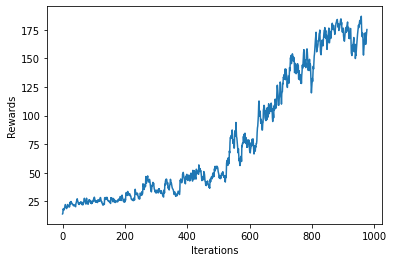

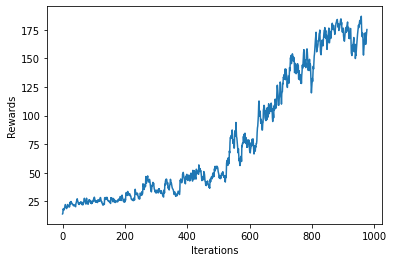

In [ ]:
# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(1000):
    memory = Memory()
    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)
        
        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            
            # initiate training - remember we don't know anything about how the 
            #   agent is doing until it has crashed!
            train_step(cartpole_model, optimizer, 
                        observations=np.vstack(memory.observations),
                        actions=torch.tensor(np.array(memory.actions), dtype=torch.long),
                        discounted_rewards = torch.tensor(discount_rewards(memory.rewards), dtype=torch.float))
            
            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

Let's checkout the trained agent's performance

In [ ]:
saved_cartpole = save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

NameError: ignored

# 3. Pong

## 3.1 Pong Environment

In [ ]:
def create_pong_env(): 
    return gym.make("Pong-v0", frameskip=5)
    
env = create_pong_env()
env.seed(1); # for reproducibility

In Pong, observations are the individual video frames (i.e., images) that depict the state of the board. Thus, the observations are **210x160 RGB images** (arrays of shape (210,160,3)).

At every time step, the agent (which controls the paddle) has **six actions** to choose from: no-op (no operation), move right, move left, fire, fire right, and fire left. 

Let's confirm the size of the obseravation & action space by querying the environment:

In [ ]:
print("Environment has observation space =", env.observation_space)

n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Environment has observation space = Box(0, 255, (210, 160, 3), uint8)
Number of possible actions that the agent can choose from = 6


The raw observation contains a lot of unuseful information for the training such as the score board and the gap separting the score board and the battle field. Therefore, it needs to be pre-processed. This pre-processed phase including

* Crop & scale the image to the size of **(40, 40)**

* Convert the resulted image into a single channel image



Text(0.5, 1.0, 'Preprocessed Observation')

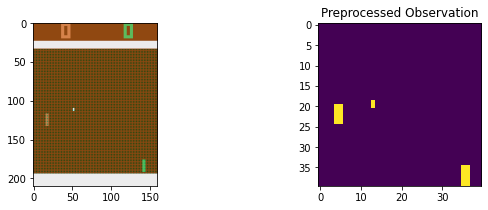

In [ ]:
observation = env.reset()
for i in range(30):
    action = np.random.choice(n_actions)
    observation, _,_,_ = env.step(action)
observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation)
ax.grid(False)
ax2.imshow(np.squeeze(observation_pp))
ax2.grid(False)
plt.title('Preprocessed Observation')

Compared to CartPole, the Pong environment is more complex and directly feeding observations to the agent's model may not work. This is due to the fact that one single frame doesn't contain enough information to infer the next move (e.g. the moving direction of the ball, the moving direction of our agent and the oppent). To provide the agent with these information, we will feed **the differnce between the current frame to the previous one** to the model. Such difference is computed by the function `mdl.lab3.pong_change`

Text(0.5, 1.0, 'Difference (Model Input)')

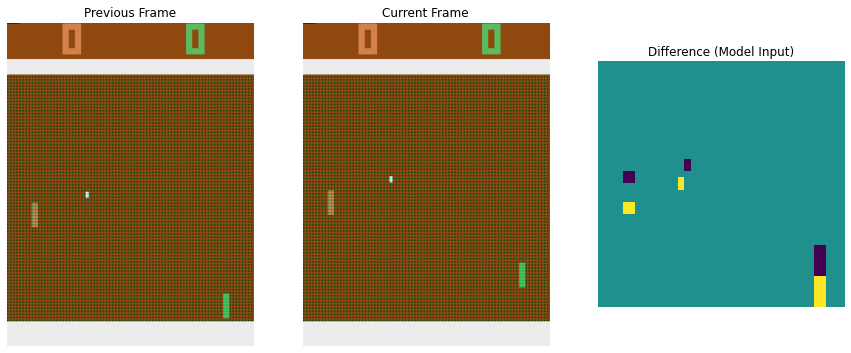

In [ ]:
next_observation, _,_,_ = env.step(np.random.choice(n_actions))
diff = mdl.lab3.pong_change(observation, next_observation)

f, ax = plt.subplots(1, 3, figsize=(15,15))
for a in ax:
    a.grid(False)
    a.axis("off")
    
ax[0].imshow(observation)
ax[0].set_title('Previous Frame')
ax[1].imshow(next_observation)
ax[1].set_title('Current Frame')
ax[2].imshow(np.squeeze(diff))
ax[2].set_title('Difference (Model Input)')

## 3.2 Pong agent

### 3.2.1 Agent's model

Since observations come in form of images, the model employed here contains a few `nn.Conv2d` layers combined with a two `nn.Linear` layers at the end to compute logits of the probability of taking **6** actions. The model's architecture is shown in the figure below

![alt text](https://drive.google.com/uc?id=1Rmr5oUNEvw6o764mCndgmLLOubBv3gLh)

Documentation of [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d). Note that in this documentation there is the formula for computing the size of Conv2d's output.

In [ ]:
def create_pong_model():
    model = nn.Sequential(
        # TODO: define the model as shown in the figure above
        # for Conv2d layer the kernel size is provided, but you
        # need to identify the value of in_channels, out_channels,
        # stride, padding from the size of intermediate tensor 
        # written on the image
        # Activation ReLU should be defined as a separate layer
        # using nn.ReLU
        # N is batch size which you shouldn't worry about
        nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
        nn.ReLU(),
        nn.Conv2d(32, 48, kernel_size=5, stride=2, padding=2),
        nn.ReLU(),
        nn.Conv2d(48, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(in_features=64, out_features=128), 
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=6), 
    )

    return model

## 3.3 Pong helper functions

While the function `chose_action`, `compute_loss` and `train_step` can be reused from CartPole, the **reward function** need to be modified for Pong because of Pong's different reward policy. To be more specific, a Pong game has ended if the reward is +1 (we won!) or -1 (we lost unfortunately). Otherwise, we expect the reward at a timestep to be zero -- the players (or agents) are just playing eachother. So, after a game ends, we will need to reset the reward to zero when a game ends

In [ ]:
def discount_rewards(rewards, gamma=0.99): 
    """Compute normalized, discounted rewards for Pong (i.e., return)
    
    Args:
        rewards (np.ndarray): reward at timesteps in episode, shape (n_rewards)
        gamma: discounting factor. Note increase to 0.99 -- 
            rate of depreciation will be slower.
    
    Returns:
        np.ndarray: normalized discounted reward for each state in the episode,
            shape (n_rewardsl)
    """
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(0, len(rewards))):
        # NEW: Reset the sum if the reward is not 0 (the game has ended!)
        if rewards[t] != 0:
            R = 0
        # update the total discounted reward as before
        R = R * gamma + rewards[t]
        discounted_rewards[t] = R
        
    return normalize(discounted_rewards)

In the training of CartPole agent, we put the code for collecting (observation, action, reward) within the main training loop. For Pong, due to the need to of pre-process observations and compute the difference between frames to form the final observations, to collection of (observation, action, reward) becomes more complicated. Therefore, it is clearer to separate this from the main training loop using the function `collect_rollout` below.

The term **rollout** refers the collection of (observation, action, reward) during an episode.

In [ ]:
def collect_rollout(batch_size, env, model, choose_action):
    """Rollout function
        Key steps for agent's operation in the environment, until completion of a rollout.
            * An observation is drawn
            * the agent (controlled by model) selects an action
            * the agent executes that action in the environment and collects rewards
            * information is added to memory.
        This is repeated until the completion of the rollout -- the Pong game ends.
        Processes multiple batches serially (i.e. one-by-one).

    Args:
        batch_size (int): number of batches (i.e. agent-env pair), 
            to be processed serially

        env: environment

        model (nn.Module): Pong agent model
        
        choose_action: choose_action function
    
    Returns:
        memories: array of Memory buffers, of length batch_size, corresponding to the
            episode executions from the rollout
    """
    # Holder array for the Memory buffers
    memories = []

    # Process batches serially by iterating through them
    for b in range(batch_size):

        # Instantiate Memory buffer, restart the environment
        memory = Memory()
        next_observation = env.reset()
        previous_frame = next_observation
        done = False # tracks whether the episode (game) is done or not

        while not done:

            current_frame = next_observation

            '''TODO: determine the observation change.
            Hint: this is the difference between the past two frames'''
            frame_diff = mdl.lab3.pong_change(previous_frame, current_frame)  # (40, 40, 1)
            # put channel dimension in the 1st place
            frame_diff = frame_diff.transpose(2, 0, 1) # (1, 40, 40) 
            
            '''TODO: choose an action for the pong model, using the frame difference, and evaluate'''
            action = choose_action(model, np.array(frame_diff), single=True)

            # Take the chosen action
            next_observation, reward, done, info = env.step(action)

            '''TODO: save the observed frame difference, the action that was taken, and the resulting reward!'''
            memory.add_to_memory(next_observation, action, reward)

            previous_frame = current_frame

        # Add the memory from this batch to the array of all Memory buffers
        memories.append(memory)

    return memories

To get a sense of what is encapsulated by collect_rollout, we will instantiate an untrained Pong model, run a single rollout using this model, save the memory, and play back the observations the model sees. Note that these will be frame differences.

In [ ]:
### Rollout with untrained Pong model ###

# Model
test_model = create_pong_model()
from torchsummary import summary
#summary(test_model, input_size=(1, 40, 40))

# Rollout with single batch
single_batch_size = 1
memories = collect_rollout(single_batch_size, env, test_model, choose_action)
rollout_video = mdl.lab3.save_video_of_memory(memories[0], "Pong-Random-Agent.mp4")

# Play back video of memories
mdl.lab3.play_video(rollout_video)

## 3.4 Training Pong

To accelerate the training process, the collection of rollout is parallelized in the function below

In [ ]:
def parallelized_collect_rollout(batch_size, envs, model, choose_action):

    assert len(envs) == batch_size, "Number of parallel environments must be equal to the batch size."

    memories = [Memory() for _ in range(batch_size)]
    next_observations = [single_env.reset() for single_env in envs]
    previous_frames = [obs for obs in next_observations]
    done = [False] * batch_size
    rewards = [0] * batch_size

    while True:

        current_frames = [obs for obs in next_observations]
        diff_frames = [mdl.lab3.pong_change(prev, curr) for (prev, curr) in zip(previous_frames, current_frames)]

        diff_frames_not_done = [diff_frames[b].transpose(2, 0, 1) for b in range(batch_size) if not done[b]]
        actions_not_done = choose_action(model, np.array(diff_frames_not_done), single=False)

        actions = [None] * batch_size
        ind_not_done = 0
        for b in range(batch_size):
            if not done[b]:
                actions[b] = actions_not_done[ind_not_done]
                ind_not_done += 1

        for b in range(batch_size):
            if done[b]:
                continue
            next_observations[b], rewards[b], done[b], info = envs[b].step(actions[b])
            previous_frames[b] = current_frames[b]
            memories[b].add_to_memory(diff_frames[b], actions[b], rewards[b])

        if all(done):
            break

    return memories

Declare hyperparamters and instantiate a Pong agent

In [ ]:
### Hyperparameters and setup for training ###
# Rerun this cell if you want to re-initialize the training process
#   (i.e., create new model, reset loss, etc)


# Hyperparameters
learning_rate = 1e-3
MAX_ITERS = 1000 # increase the maximum to train longer
batch_size = 5 # number of batches to run

# Model, optimizer
pong_model = create_pong_model()
optimizer = torch.optim.Adam(pong_model.parameters(), learning_rate)
iteration = 0 # counter for training steps

# Plotting
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
smoothed_reward.append(0) # start the reward at zero for baseline comparison
plotter = mdl.util.PeriodicPlotter(sec=15, xlabel='Iterations', ylabel='Win Percentage (%)')

# Batches and environment
# To parallelize batches, we need to make multiple copies of the environment.
envs = [create_pong_env() for _ in range(batch_size)] # For parallelization

The main training loop

In [ ]:
### Training Pong ###
# You can run this cell and stop it anytime in the middle of training to save 
#   a progress video (see next codeblock). To continue training, simply run this 
#   cell again, your model will pick up right where it left off. To reset training,
#   you need to run the cell above. 



games_to_win_episode = 21 # this is set by OpenAI gym and cannot be changed.
print(torch.cuda.get_device_name())
# Main training loop
while iteration < MAX_ITERS:

    plotter.plot(smoothed_reward.get())

    tic = time.time()
    # RL agent algorithm. By default, uses serial batch processing.
    # memories = collect_rollout(batch_size, env, pong_model, choose_action)

    # Parallelized version. Uncomment line below (and comment out line above) to parallelize
    memories = parallelized_collect_rollout(batch_size, envs, pong_model, choose_action)
    print(time.time()-tic)

    # Aggregate memories from multiple batches
    batch_memory = mdl.lab3.aggregate_memories(memories)

    # Track performance based on win percentage (calculated from rewards)
    total_wins = sum(np.array(batch_memory.rewards) == 1)
    total_games = sum(np.abs(np.array(batch_memory.rewards)))
    win_rate = total_wins / total_games
    smoothed_reward.append(100 * win_rate)

    # Training!
    train_step(
        pong_model,
        optimizer,
        observations = np.stack(batch_memory.observations, 0).transpose(0, 3, 1, 2),
        actions = torch.tensor(np.array(batch_memory.actions), dtype=torch.long),
        discounted_rewards = torch.tensor(discount_rewards(batch_memory.rewards), dtype=torch.float)
    )

    # Save a video of progress -- this can be played back later
    if iteration % 100 == 0:
        save_video_of_model(pong_model, "Pong-v0", suffix="_"+str(iteration))
                                                    

    iteration += 1 # Mark next episode

Tesla K80


RuntimeError: ignored

Let's checkout how the trained agent plays

In [ ]:
latest_pong = save_video_of_model(pong_model, "Pong-v0", suffix="_latest")
mdl.lab3.play_video(latest_pong, width=400)